# 06 — Modeling Satellite + Tabular

## Baselines + Models

**DSRF + MCMIPF fusion with tabular, with MLflow tracking**

**Optuna (JournalStorage + lock)**

In [15]:
from pathlib import Path
import os, json, math, time, random, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

import mlflow
import mlflow.keras

### Config

In [16]:
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

gpus = tf.config.list_physical_devices('GPU')
for g in gpus:
    try:
        tf.config.experimental.set_memory_growth(g, True)
    except Exception:
        pass
print("TF GPUs:", gpus)

# Rutas
ROOT = Path("..").resolve()
DATA_CLEAN = ROOT / "data" / "clean" / "base_dataset.csv"
GOES_DIR   = ROOT / "data" / "GOES_v2"
MCMIPF_DIR = GOES_DIR / "MCMIPF"

OUT_DIR = ROOT / "outputs"
OUT_DIR.mkdir(parents=True, exist_ok=True)
ART_DIR = OUT_DIR / "artifacts_mcmipf_cnnlite"
ART_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR = OUT_DIR / "figures" / "mcmipf_cnnlite"
FIG_DIR.mkdir(parents=True, exist_ok=True)

TARGET_COL = "GHI"
FREQ = "10T"

# Ventanas
DEFAULT_INPUT_STEPS   = 18   # 18 * 10 min = 3h de historia
DEFAULT_HORIZON_STEPS = 6    # 6 * 10 min = 1h adelante

PATIENCE = 6

IMG_SIZE = 32      # tamaño de imagen (32x32)
SUBSAMPLE = 1      # 1 = usar cada 10 min.

MLFLOW_DIR = (OUT_DIR / "mlruns").resolve()
mlflow.set_tracking_uri("file://" + str(MLFLOW_DIR))
mlflow.set_experiment("pg_industrial_satellite_MCMIPF_CNNLite")
mlflow.keras.autolog(log_models=False)
print("MLflow tracking:", MLFLOW_DIR)

2025/11/22 17:31:26 INFO mlflow.tracking.fluent: Experiment with name 'pg_industrial_satellite_MCMIPF_CNNLite' does not exist. Creating a new experiment.


TF GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
MLflow tracking: /mnt/SOLARLAB/E_Ladino/Repo_2/solar-forecasting-colombia/outputs/mlruns


### Data

In [17]:
df_full = pd.read_csv(DATA_CLEAN, parse_dates=[0], index_col=0).sort_index()
df_full.index.name = "time"

# Submuestreo
idx = np.arange(len(df_full))
keep_mask = (idx % SUBSAMPLE) == 0
df = df_full.iloc[keep_mask].copy()
print("Tamaño original:", len(df_full), " → submuestreado:", len(df))

# Features tabulares
base_feats = [
    'Presion','TempAmb','WindSpeed','WindDirection',
    'hour_sin','hour_cos','DoY Sin','DoY Cos',
    'solar_zenith','solar_azimuth','solar_elevation',
    'TempAmb_roll1h_mean','TempAmb_roll6h_mean',
    'Presion_roll1h_mean','Presion_roll6h_mean',
    'WindSpeed_roll1h_mean','WindSpeed_roll6h_mean',
    'temp_pressure_ratio','wind_temp_interaction'
]
ghi_lags  = [c for c in ['GHI_lag1','GHI_lag3','GHI_lag6','GHI_lag12','GHI_lag36'] if c in df.columns]
ghi_rolls = [c for c in ['GHI_roll1h_mean','GHI_roll3h_mean','GHI_roll6h_mean','GHI_roll1h_max'] if c in df.columns]
feat_cols = [c for c in base_feats if c in df.columns] + ghi_lags + ghi_rolls
print(f"Total features used (tabular): {len(feat_cols)}")
print(feat_cols)

assert TARGET_COL in df.columns, f"TARGET_COL='{TARGET_COL}' no existe en el dataset"

# Split temporal
n = len(df); i_tr = int(0.7*n); i_va = int(0.85*n)
df_train, df_val, df_test = df.iloc[:i_tr], df.iloc[i_tr:i_va], df.iloc[i_va:]

# Escalado
X_scaler = StandardScaler(); y_scaler = StandardScaler()
X_train = X_scaler.fit_transform(df_train[feat_cols].values)
X_val   = X_scaler.transform(df_val[feat_cols].values)
X_test  = X_scaler.transform(df_test[feat_cols].values)

y_train = y_scaler.fit_transform(df_train[[TARGET_COL]].values).ravel()
y_val   = y_scaler.transform(df_val[[TARGET_COL]].values).ravel()
y_test  = y_scaler.transform(df_test[[TARGET_COL]].values).ravel()

imp = SimpleImputer(strategy="median")
X_train = imp.fit_transform(X_train)
X_val   = imp.transform(X_val)
X_test  = imp.transform(X_test)

for name, arr in [("X_train",X_train),("X_val",X_val),("X_test",X_test),
                  ("y_train",y_train),("y_val",y_val),("y_test",y_test)]:
    assert np.isfinite(arr).all(), f"{name} tiene NaN/Inf"

time_index = df.index
time_train, time_val, time_test = time_index[:i_tr], time_index[i_tr:i_va], time_index[i_va:]
print("N train/val/test (submuestreado):", len(time_train), len(time_val), len(time_test))

Tamaño original: 107172  → submuestreado: 107172
Total features used (tabular): 28
['Presion', 'TempAmb', 'WindSpeed', 'WindDirection', 'hour_sin', 'hour_cos', 'DoY Sin', 'DoY Cos', 'solar_zenith', 'solar_azimuth', 'solar_elevation', 'TempAmb_roll1h_mean', 'TempAmb_roll6h_mean', 'Presion_roll1h_mean', 'Presion_roll6h_mean', 'WindSpeed_roll1h_mean', 'WindSpeed_roll6h_mean', 'temp_pressure_ratio', 'wind_temp_interaction', 'GHI_lag1', 'GHI_lag3', 'GHI_lag6', 'GHI_lag12', 'GHI_lag36', 'GHI_roll1h_mean', 'GHI_roll3h_mean', 'GHI_roll6h_mean', 'GHI_roll1h_max']
N train/val/test (submuestreado): 75020 16076 16076


### Helpers

In [18]:
def metrics_from_scaled(pred_scaled, true_scaled, y_scaler):
    """
    Recibe predicciones y verdaderos en espacio escalado (z-score) y los
    lleva de vuelta a W/m² para calcular métricas.
    """
    p = y_scaler.inverse_transform(pred_scaled.reshape(-1,1)).ravel()
    t = y_scaler.inverse_transform(true_scaled.reshape(-1,1)).ravel()

    mask = np.isfinite(p) & np.isfinite(t)
    if mask.sum() == 0:
        print("[metrics_from_scaled] Sin valores finitos.")
        metrics = {k: float("nan") for k in ["MAE","RMSE","MAPE","sMAPE","R2"]}
        return metrics, (t, p)

    if mask.sum() < len(p):
        print(f"[metrics_from_scaled] WARNING: filtrados {len(p) - mask.sum()} puntos no finitos.")

    p = p[mask]; t = t[mask]

    mae = mean_absolute_error(t, p)
    rmse = float(np.sqrt(mean_squared_error(t, p)))
    mape = float(np.mean(np.abs(t - p) / (np.abs(t) + 1e-6)) * 100)
    smape = float(100 * np.mean(2*np.abs(p - t) / (np.abs(t) + np.abs(p) + 1e-6)))
    r2 = float(r2_score(t, p))
    return {"MAE": mae, "RMSE": rmse, "MAPE": mape, "sMAPE": smape, "R2": r2}, (t, p)

def _rmse(a,b):
    return float(np.sqrt(mean_squared_error(a,b)))

def build_seq_arrays_img_only(imgs_4d, y_1d, L, horizon, stride=1):
    """
    Secuencias sólo imágenes:
      imgs_4d: (N, H, W, C)
      y_1d   : (N,)
    Devuelve:
      X_img_seq: (N', L, H, W, C)
      y_seq    : (N',)
    """
    N = imgs_4d.shape[0]
    assert len(y_1d) == N
    H, W, C = imgs_4d.shape[1:]
    outX, outy = [], []
    last = N - L - horizon + 1
    if last <= 0:
        return (np.zeros((0, L, H, W, C), dtype="float32"),
                np.zeros((0,), dtype="float32"))
    for i in range(0, last, stride):
        block_img = imgs_4d[i:i+L]
        outX.append(block_img)
        outy.append(y_1d[i + L + horizon - 1])
    return np.asarray(outX, dtype="float32"), np.asarray(outy, dtype="float32")

def build_seq_arrays_img_tab(imgs_4d, X_tab_2d, y_1d, L, horizon, stride=1):
    """
    Secuencias conjuntas imágenes + tabular:

      imgs_4d : (N, H, W, C)
      X_tab_2d: (N, D)
      y_1d    : (N,)

    Devuelve:
      X_img_seq: (M, L, H, W, C)
      X_tab_seq: (M, L, D)
      y_seq    : (M,)
    """
    N = imgs_4d.shape[0]
    assert X_tab_2d.shape[0] == N
    assert len(y_1d) == N

    H, W, C = imgs_4d.shape[1:]
    D = X_tab_2d.shape[1]

    outX_img, outX_tab, outy = [], [], []
    last = N - L - horizon + 1
    if last <= 0:
        return (np.zeros((0, L, H, W, C), dtype="float32"),
                np.zeros((0, L, D), dtype="float32"),
                np.zeros((0,), dtype="float32"))

    for i in range(0, last, stride):
        block_img = imgs_4d[i:i+L]
        block_tab = X_tab_2d[i:i+L]
        outX_img.append(block_img)
        outX_tab.append(block_tab)
        outy.append(y_1d[i + L + horizon - 1])

    return (np.asarray(outX_img, dtype="float32"),
            np.asarray(outX_tab, dtype="float32"),
            np.asarray(outy, dtype="float32"))

### Satellite

In [19]:
DSRF_DIR   = GOES_DIR / "DSRF"
MCMIPF_DIR = GOES_DIR / "MCMIPF"

In [20]:
def build_mcmipf_multichannel(time_index,
                              target_size=IMG_SIZE,
                              sel_channels=(1,2,3,5,7,10,13,15)):
    """
    Construye:
      mcm_all: (N, H, W, C) con C = len(sel_channels)

    Pasos:
      - Horas únicas de df.index (floor a hora).
      - Carga cada archivo MCMIPF una vez:
          (6,16,256,256) → (6,C,H,W) → (6,H,W,C)
      - Para cada timestamp (10-min submuestreado):
          slot = minute // 10 ∈ [0,5]
          imagen = seq[slot]
      - Horas sin archivo: imagen 0.
      - Luego normalización canal a canal.
    """
    hours = time_index.floor("H")
    unique_hours = sorted(hours.unique())

    hour_to_seq = {}
    missing_hours = 0

    assert 256 % target_size == 0
    step = 256 // target_size
    sel_channels = tuple(sel_channels)

    # 1) Carga por hora
    all_imgs_list = []
    for h in unique_hours:
        key = h.strftime("%Y%m%d_%H")
        year = key[:4]
        month = key[4:6]
        fname = f"{key}_MCMIPF.npz"
        path = MCMIPF_DIR / year / month / fname
        if not path.exists():
            # 6 frames hora, llenos de ceros
            seq = np.zeros((6, target_size, target_size, len(sel_channels)),
                           dtype="float32")
            hour_to_seq[key] = seq
            missing_hours += 1
            continue

        data = np.load(path)
        arr = data[list(data.files)[0]]  # (6,16,256,256)
        arr = arr.astype("float32")[:, sel_channels, ::step, ::step]  # (6,C,H,W)
        arr = np.transpose(arr, (0, 2, 3, 1))  # (6,H,W,C)
        # Guardar
        hour_to_seq[key] = arr
        all_imgs_list.append(arr)

    print(f"MCMIPF: horas únicas en df(sub)      = {len(unique_hours)}")
    print(f"MCMIPF: horas sin archivo NOAA (sub) = {missing_hours}")

    if len(all_imgs_list) == 0:
        raise RuntimeError("No se pudo cargar ningún archivo MCMIPF.")

    all_imgs = np.concatenate(all_imgs_list, axis=0)  # (6*Hrs, H,W,C)
    all_imgs = np.nan_to_num(all_imgs, nan=0.0, posinf=0.0, neginf=0.0)

    # 2) Normalización canal a canal
    C = all_imgs.shape[-1]
    flat = all_imgs.reshape(-1, C)
    mean_ch = flat.mean(axis=0)
    std_ch  = flat.std(axis=0) + 1e-6
    print("MCMIPF per-channel mean:", mean_ch)
    print("MCMIPF per-channel std :", std_ch)

    # 3) Secuencia completa alineada a time_index
    imgs = []
    for ts in time_index:
        key = ts.strftime("%Y%m%d_%H")
        seq = hour_to_seq.get(key, None)
        if seq is None:
            # fallback (no debería pasar si arriba rellenamos)
            frame = np.zeros((target_size,target_size,len(sel_channels)), dtype="float32")
        else:
            slot = ts.minute // 10  # 0..5
            slot = min(max(slot,0), 5)
            frame = seq[slot]
        frame = np.nan_to_num(frame, nan=0.0, posinf=0.0, neginf=0.0)
        # Normalizar canal a canal
        frame = (frame - mean_ch) / std_ch
        imgs.append(frame)

    mcm_all = np.stack(imgs, axis=0).astype("float32")
    return mcm_all


In [ ]:
print(f"→ Cargando MCMIPF completo (submuestreado, {IMG_SIZE}x{IMG_SIZE}, 8 canales)...")
mcmipf_all = build_mcmipf_multichannel(time_index,
                                       target_size=IMG_SIZE,
                                       sel_channels=(1,2,3,5,7,10,13,15))
print("MCMIPF_all:", mcmipf_all.shape)

→ Cargando MCMIPF completo (submuestreado, 32x32, 8 canales)...


In [ ]:
mcm_train, mcm_val, mcm_test = mcmipf_all[:i_tr], mcmipf_all[i_tr:i_va], mcmipf_all[i_va:]

for name, arr in [("mcm_train",mcm_train),("mcm_val",mcm_val),("mcm_test",mcm_test)]:
    assert np.isfinite(arr).all(), f"{name} tiene NaN/Inf después de normalizar"
print("Tensores MCMIPF listos.")

Tensores MCMIPF listos.


### Models

1) CNN-Lite + LSTM (solo MCMIPF)
2) CNN-Lite + LSTM (MCMIPF) + LSTM (tabular) → fusión


In [ ]:
def make_cnn_block_for_mcm(H, W, C, emb_dim=64, name_prefix="mcm_cnn"):
    """
    CNN ligera para un solo frame MCMIPF (H,W,C) → embedding 1D
    """
    model = models.Sequential(name=name_prefix)
    model.add(layers.Conv2D(32, (3,3), padding="same", activation="relu", input_shape=(H,W,C)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Conv2D(64, (3,3), padding="same", activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Conv2D(128, (3,3), padding="same", activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.GlobalAveragePooling2D())

    model.add(layers.Dense(emb_dim, activation="relu"))
    return model

def build_mcmipf_cnn_lstm_model(L, H=IMG_SIZE, W=IMG_SIZE, C=8,
                                emb_dim=64,
                                lstm_units=64,
                                dense_units=64,
                                dropout_rate=0.3):
    """
    Modelo sólo imágenes MCMIPF:
      Input: (L, H, W, C)
      TimeDistributed(CNN-lite) → (L, emb_dim)
      LSTM → Dense → GHI
    """
    inp_img = layers.Input(shape=(L, H, W, C), name="img_seq")

    cnn_block = make_cnn_block_for_mcm(H, W, C, emb_dim=emb_dim, name_prefix="mcm_cnn_frame")
    x = layers.TimeDistributed(cnn_block, name="td_mcm_cnn")(inp_img)
    x = layers.LSTM(lstm_units, activation="tanh", name="lstm_img")(x)
    x = layers.Dense(dense_units, activation="relu")(x)
    x = layers.Dropout(dropout_rate)(x)
    out = layers.Dense(1, dtype="float32", name="y_hat")(x)

    model = models.Model(inp_img, out, name="MCMIPF_CNN_LSTM_only")
    return model

def build_mcmipf_tabular_fusion_model(L,
                                      tab_dim,
                                      H=IMG_SIZE, W=IMG_SIZE, C=8,
                                      emb_dim=64,
                                      lstm_img_units=64,
                                      lstm_tab_units=64,
                                      dense_fusion_units=64,
                                      dropout_rate=0.3):
    """
    Fusión:
      - rama imágenes: TimeDistributed(CNN-lite) → LSTM_img
      - rama tabular : LSTM_tab
      - concat → Dense → Dropout → Dense(1)
    """
    # Imágenes
    inp_img = layers.Input(shape=(L, H, W, C), name="img_seq")
    cnn_block = make_cnn_block_for_mcm(H, W, C, emb_dim=emb_dim, name_prefix="mcm_cnn_frame")
    x_img = layers.TimeDistributed(cnn_block, name="td_mcm_cnn")(inp_img)
    x_img = layers.LSTM(lstm_img_units, activation="tanh", name="lstm_img")(x_img)

    # Tabular
    inp_tab = layers.Input(shape=(L, tab_dim), name="tab_seq")
    x_tab = layers.LSTM(lstm_tab_units, activation="tanh", name="lstm_tab")(inp_tab)

    # Fusión
    x = layers.concatenate([x_img, x_tab], name="fusion_concat")
    x = layers.Dense(dense_fusion_units, activation="relu", name="fusion_dense")(x)
    x = layers.Dropout(dropout_rate, name="fusion_dropout")(x)
    out = layers.Dense(1, dtype="float32", name="y_hat")(x)

    model = models.Model([inp_img, inp_tab], out, name="MCMIPF_Tabular_Fusion_CNNLite")
    return model

### Plots

In [ ]:
def plot_sample_series(y_true, y_pred, title, n=1000, fname=None):
    n = min(n, len(y_true))
    plt.figure(figsize=(11,3.8))
    plt.plot(y_true[:n], label="Real", lw=1.5)
    plt.plot(y_pred[:n], label="Pred", lw=1.2, alpha=0.9)
    plt.title(title); plt.xlabel("Time steps (submuestreados)")
    plt.ylabel("GHI (W/m²)")
    plt.legend(frameon=False); plt.tight_layout()
    if fname is not None:
        plt.savefig(fname, dpi=140)
    plt.show()

### Training

#### Training — 1) Sólo imágenes MCMIPF

In [ ]:
def train_mcmipf_cnn_lstm(input_steps=DEFAULT_INPUT_STEPS,
                          horizon_steps=DEFAULT_HORIZON_STEPS,
                          lr=5e-4,
                          batch_size=4,
                          epochs=20,
                          stride=2):
    """
    Modelo sólo imágenes MCMIPF con CNN-lite + LSTM.
    """

    Xtr_img_seq, ytr_seq = build_seq_arrays_img_only(
        imgs_4d=mcm_train, y_1d=y_train,
        L=input_steps, horizon=horizon_steps,
        stride=stride
    )
    Xva_img_seq, yva_seq = build_seq_arrays_img_only(
        imgs_4d=mcm_val, y_1d=y_val,
        L=input_steps, horizon=horizon_steps,
        stride=stride
    )

    print("MCMIPF CNN-LSTM (solo imágenes) shapes:")
    print("Xtr_img_seq:", Xtr_img_seq.shape)
    print("ytr_seq    :", ytr_seq.shape)

    if Xtr_img_seq.shape[0] == 0:
        raise RuntimeError("No hay muestras de entrenamiento (revisa L/horizon/stride).")

    L = input_steps
    H, W, C = Xtr_img_seq.shape[2:]

    model = build_mcmipf_cnn_lstm_model(
        L=L, H=H, W=W, C=C,
        emb_dim=64,
        lstm_units=64,
        dense_units=64,
        dropout_rate=0.3
    )

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss="mse")

    ckpt = (ART_DIR / "best_mcmipf_cnn_lstm_only.weights.h5").resolve()
    cbs = [
        callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE+2,
                                restore_best_weights=True, verbose=1),
        callbacks.ModelCheckpoint(filepath=str(ckpt), monitor="val_loss",
                                  save_best_only=True, save_weights_only=True)
    ]

    with mlflow.start_run(run_name="MCMIPF_CNN_LSTM_only"):
        mlflow.log_param("mode",          "img_only")
        mlflow.log_param("input_steps",   input_steps)
        mlflow.log_param("horizon_steps", horizon_steps)
        mlflow.log_param("lr",            lr)
        mlflow.log_param("batch_size",    batch_size)
        mlflow.log_param("epochs",        epochs)
        mlflow.log_param("stride",        stride)
        mlflow.log_param("img_H",         H)
        mlflow.log_param("img_W",         W)
        mlflow.log_param("img_C",         C)

        hist = model.fit(
            Xtr_img_seq, ytr_seq,
            validation_data=(Xva_img_seq, yva_seq),
            epochs=epochs,
            batch_size=batch_size,
            verbose=1,
            callbacks=cbs,
            shuffle=True
        )

        # Test
        Xte_img_seq, yte_seq = build_seq_arrays_img_only(
            imgs_4d=mcm_test, y_1d=y_test,
            L=input_steps, horizon=horizon_steps,
            stride=stride
        )
        yhat_test_scaled = model.predict(Xte_img_seq, verbose=0).squeeze()

        metrics, (t_o, p_o) = metrics_from_scaled(yhat_test_scaled, yte_seq, y_scaler)
        for k,v in metrics.items():
            mlflow.log_metric(f"test_{k}", float(v))

        # Log modelo (sin firma para no complicar)
        mlflow.keras.log_model(
            model,
            artifact_path="MCMIPF_CNN_LSTM_only"
        )

        print("MCMIPF CNN-LSTM test metrics:", metrics)

    return model, metrics, (t_o, p_o)

#### Training — 2) Fusión MCMIPF + Tabular

In [ ]:
def train_mcmipf_tabular_fusion(input_steps=DEFAULT_INPUT_STEPS,
                                horizon_steps=DEFAULT_HORIZON_STEPS,
                                lr=5e-4,
                                batch_size=4,
                                epochs=20,
                                stride=2):
    """
    Modelo que integra:
      - secuencias tabulares (L, F)
      - secuencias de imágenes MCMIPF (L, H, W, C)
    """

    Xtr_img_seq, Xtr_tab_seq, ytr_seq = build_seq_arrays_img_tab(
        imgs_4d=mcm_train, X_tab_2d=X_train, y_1d=y_train,
        L=input_steps, horizon=horizon_steps, stride=stride
    )
    Xva_img_seq, Xva_tab_seq, yva_seq = build_seq_arrays_img_tab(
        imgs_4d=mcm_val, X_tab_2d=X_val, y_1d=y_val,
        L=input_steps, horizon=horizon_steps, stride=stride
    )

    print("MCMIPF+Tabular fusion shapes:")
    print("Xtr_img_seq:", Xtr_img_seq.shape)
    print("Xtr_tab_seq:", Xtr_tab_seq.shape)
    print("ytr_seq    :", ytr_seq.shape)

    if Xtr_img_seq.shape[0] == 0:
        raise RuntimeError("No hay muestras de entrenamiento (revisa L/horizon/stride).")

    L = input_steps
    H, W, C = Xtr_img_seq.shape[2:]
    tab_dim = Xtr_tab_seq.shape[-1]

    model = build_mcmipf_tabular_fusion_model(
        L=L, tab_dim=tab_dim,
        H=H, W=W, C=C,
        emb_dim=64,
        lstm_img_units=64,
        lstm_tab_units=64,
        dense_fusion_units=64,
        dropout_rate=0.3
    )

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss="mse")

    ckpt = (ART_DIR / "best_mcmipf_tabular_fusion.weights.h5").resolve()
    cbs = [
        callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE+2,
                                restore_best_weights=True, verbose=1),
        callbacks.ModelCheckpoint(filepath=str(ckpt), monitor="val_loss",
                                  save_best_only=True, save_weights_only=True)
    ]

    with mlflow.start_run(run_name="MCMIPF_Tabular_Fusion_CNNLite"):
        mlflow.log_param("mode",          "img+tab_fusion")
        mlflow.log_param("input_steps",   input_steps)
        mlflow.log_param("horizon_steps", horizon_steps)
        mlflow.log_param("lr",            lr)
        mlflow.log_param("batch_size",    batch_size)
        mlflow.log_param("epochs",        epochs)
        mlflow.log_param("stride",        stride)
        mlflow.log_param("img_H",         H)
        mlflow.log_param("img_W",         W)
        mlflow.log_param("img_C",         C)
        mlflow.log_param("tab_dim",       tab_dim)

        hist = model.fit(
            {"img_seq": Xtr_img_seq, "tab_seq": Xtr_tab_seq},
            ytr_seq,
            validation_data=(
                {"img_seq": Xva_img_seq, "tab_seq": Xva_tab_seq},
                yva_seq
            ),
            epochs=epochs,
            batch_size=batch_size,
            verbose=1,
            callbacks=cbs,
            shuffle=True
        )

        # Test
        Xte_img_seq, Xte_tab_seq, yte_seq = build_seq_arrays_img_tab(
            imgs_4d=mcm_test, X_tab_2d=X_test, y_1d=y_test,
            L=input_steps, horizon=horizon_steps, stride=stride
        )
        yhat_test_scaled = model.predict(
            {"img_seq": Xte_img_seq, "tab_seq": Xte_tab_seq},
            verbose=0
        ).squeeze()

        metrics, (t_o, p_o) = metrics_from_scaled(yhat_test_scaled, yte_seq, y_scaler)
        for k,v in metrics.items():
            mlflow.log_metric(f"test_{k}", float(v))

        mlflow.keras.log_model(
            model,
            artifact_path="MCMIPF_Tabular_Fusion_CNNLite"
        )

        print("MCMIPF + Tabular fusion test metrics:", metrics)

    return model, metrics, (t_o, p_o)

# Execution

build_seq_arrays_img_only: ventanas saltadas por NaNs = 415
build_seq_arrays_img_only: ventanas saltadas por NaNs = 118
VGG19+MCMIPF (solo imágenes) shapes:
Xtr_img_seq: (5828, 12, 64, 64, 3)
ytr_seq    : (5828,)


I0000 00:00:1763844190.573966 3999647 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 17624 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


Epoch 1/15


I0000 00:00:1763844203.458474  874395 cuda_dnn.cc:529] Loaded cuDNN version 90101


1457/1457 ━━━━━━━━━━━━━━━━━━━━ 45s 29ms/step - loss: 0.9643 - val_loss: 0.8049
Epoch 2/15
1457/1457 ━━━━━━━━━━━━━━━━━━━━ 39s 27ms/step - loss: 0.8794 - val_loss: 0.7477
Epoch 3/15
1457/1457 ━━━━━━━━━━━━━━━━━━━━ 34s 22ms/step - loss: 0.8568 - val_loss: 0.7819
Epoch 4/15
1457/1457 ━━━━━━━━━━━━━━━━━━━━ 39s 27ms/step - loss: 0.8070 - val_loss: 0.7434
Epoch 5/15
1457/1457 ━━━━━━━━━━━━━━━━━━━━ 32s 22ms/step - loss: 0.7772 - val_loss: 0.7661
Epoch 6/15
1457/1457 ━━━━━━━━━━━━━━━━━━━━ 32s 22ms/step - loss: 0.7384 - val_loss: 0.7497
Epoch 7/15
1457/1457 ━━━━━━━━━━━━━━━━━━━━ 40s 27ms/step - loss: 0.7186 - val_loss: 0.7297
Epoch 8/15
1457/1457 ━━━━━━━━━━━━━━━━━━━━ 40s 28ms/step - loss: 0.6855 - val_loss: 0.7314
Epoch 9/15
1457/1457 ━━━━━━━━━━━━━━━━━━━━ 48s 33ms/step - loss: 0.6787 - val_loss: 0.7207
Epoch 10/15
1457/1457 ━━━━━━━━━━━━━━━━━━━━ 48s 33ms/step - loss: 0.6777 - val_loss: 0.6887
Epoch 11/15
1457/1457 ━━━━━━━━━━━━━━━━━━━━ 40s 28ms/step - loss: 0.6730 - val_loss: 0.6932
Epoch 12/15
1457/14

2025/11/22 15:53:25 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/22 15:53:25 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/11/22 15:53:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


VGG19+MCMIPF test metrics: {'MAE': 233.8740997314453, 'RMSE': 286.69039539632297, 'MAPE': 427011200.0, 'sMAPE': 130.2539825439453, 'R2': 0.23322135210037231}


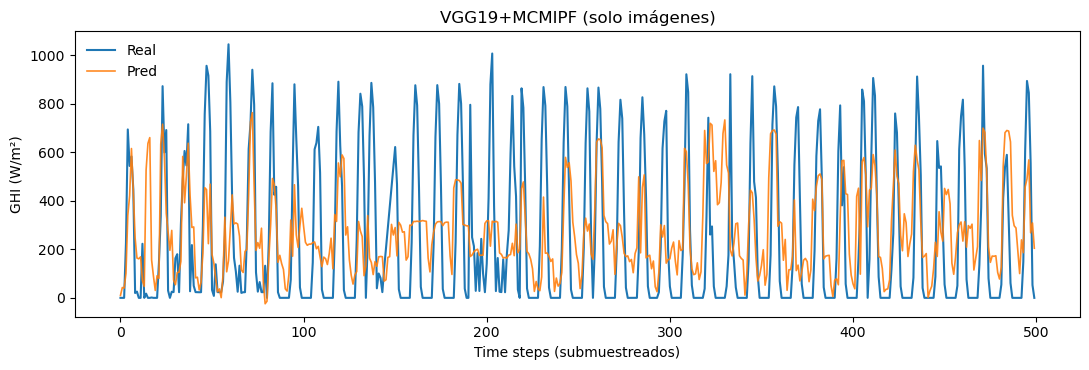

build_seq_arrays_img_tab: ventanas saltadas por NaNs = 415
build_seq_arrays_img_tab: ventanas saltadas por NaNs = 118
VGG19+MCMIPF+Tabular (fusión) shapes:
Xtr_img_seq: (5828, 12, 64, 64, 3)
Xtr_tab_seq: (5828, 12, 28)
ytr_seq    : (5828,)
Epoch 1/15
1457/1457 ━━━━━━━━━━━━━━━━━━━━ 53s 34ms/step - loss: 0.2766 - val_loss: 0.2518
Epoch 2/15
1457/1457 ━━━━━━━━━━━━━━━━━━━━ 49s 34ms/step - loss: 0.2025 - val_loss: 0.2511
Epoch 3/15
1457/1457 ━━━━━━━━━━━━━━━━━━━━ 49s 34ms/step - loss: 0.1928 - val_loss: 0.2111
Epoch 4/15
1457/1457 ━━━━━━━━━━━━━━━━━━━━ 41s 28ms/step - loss: 0.1762 - val_loss: 0.2293
Epoch 5/15
1457/1457 ━━━━━━━━━━━━━━━━━━━━ 41s 28ms/step - loss: 0.1777 - val_loss: 0.2312
Epoch 6/15
1457/1457 ━━━━━━━━━━━━━━━━━━━━ 42s 29ms/step - loss: 0.1691 - val_loss: 0.2298
Epoch 7/15
1457/1457 ━━━━━━━━━━━━━━━━━━━━ 42s 29ms/step - loss: 0.1616 - val_loss: 0.2139
Epoch 8/15
1457/1457 ━━━━━━━━━━━━━━━━━━━━ 42s 29ms/step - loss: 0.1571 - val_loss: 0.2425
Epoch 9/15
1457/1457 ━━━━━━━━━━━━━━━━━━━

2025/11/22 16:01:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/22 16:01:55 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/11/22 16:01:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


VGG19+MCMIPF+Tabular (fusión) test metrics: {'MAE': 86.71527862548828, 'RMSE': 137.97413282251495, 'MAPE': 57706812.0, 'sMAPE': 111.0189437866211, 'R2': 0.8224015831947327}


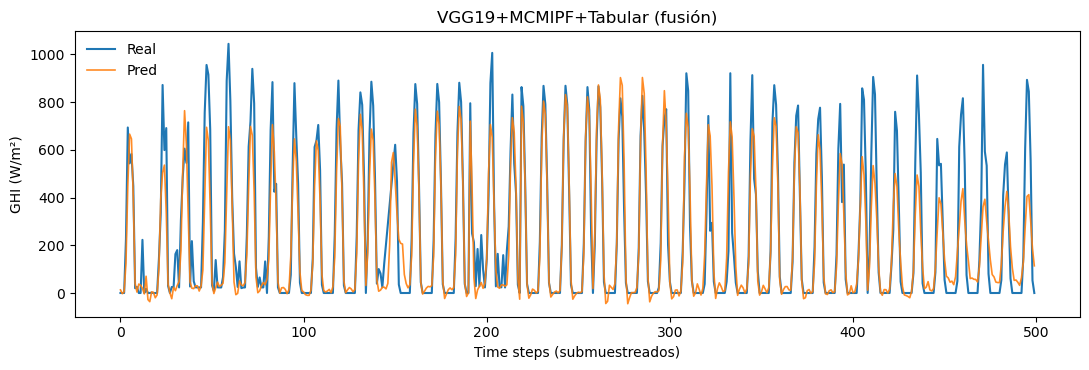

In [ ]:
if __name__ == "__main__":
    # 1) Solo imágenes MCMIPF
    model_img, metrics_img, (t_img, p_img) = train_mcmipf_cnn_lstm(
        input_steps=DEFAULT_INPUT_STEPS,
        horizon_steps=DEFAULT_HORIZON_STEPS,
        lr=5e-4,
        batch_size=4,
        epochs=15,
        stride=2
    )
    print("MCMIPF CNN-LSTM metrics:", metrics_img)
    plot_sample_series(
        t_img, p_img,
        "MCMIPF CNN-LSTM — Test (sample)",
        n=500,
        fname=FIG_DIR / "mcmipf_cnn_lstm_only_series.png"
    )

    # 2) Fusión MCMIPF + Tabular
    model_fus, metrics_fus, (t_fus, p_fus) = train_mcmipf_tabular_fusion(
        input_steps=DEFAULT_INPUT_STEPS,
        horizon_steps=DEFAULT_HORIZON_STEPS,
        lr=5e-4,
        batch_size=4,
        epochs=20,
        stride=2
    )
    print("MCMIPF + Tabular fusion metrics:", metrics_fus)
    plot_sample_series(
        t_fus, p_fus,
        "MCMIPF + Tabular Fusion — Test (sample)",
        n=500,
        fname=FIG_DIR / "mcmipf_tabular_fusion_cnnlite_series.png"
    )

    # Comparación rápida
    res = pd.DataFrame({
        "MCMIPF_CNN_LSTM_only": metrics_img,
        "MCMIPF_Tabular_Fusion_CNNLite": metrics_fus,
    }).T
    print(res.round(3).to_string())